# Predicting NBA Engagements on Instagram

## Getting Setup

In [1]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize

## Preprossesing the Data

The data we want for training is in the training_set.csv file.

We will be using trained models to predict engagements for the post in the holdout_set.csv.

In [2]:
# Read in Data
data = pd.read_csv('training_set.csv', encoding='cp1252')
data.head()

,Engagements,Followers at Posting,Created,Type,Description
0,502093,36984682,2019-05-21 23:30:51 EDT,Video,The @raptors bench trio of @sergeibaka @norman...
1,603380,36984682,2019-05-21 22:53:33 EDT,Video,@kyle_lowry7 pulls from deep for the @raptors ...
2,603380,36984682,2019-05-21 22:19:58 EDT,Video,@k_mid22 with some english on the @bucks dime!
3,725100,36984682,2019-05-21 22:02:41 EDT,Video,Kawhi punches it home with the left on TNT!
4,661446,36984682,2019-05-21 20:47:49 EDT,Video,@giannis_an34 goes baseline early to rock the ...


After reading in the data we can see some features we will have to engineer: Created, Type, and Description.

Before moving to those I am going to standardize the Engagements and Followers at Posting features.

Due to the large difference in mean and variance between the 2 columns I thought standardizing would be good for regression.

I saved the mean engagements and standard deviation so that we could convert the predictions back to the actual numbers.

In [6]:
# Standardize Engagements and Followers at Posting
def standardize(v):
    """
    Takes a single column of a DataFrame and returns a new column 
    with the data standardized (mean 0, std deviation 1)
    """
    std = v.std()
    if std == 0:
        return np.zeros(len(v))
    else:
        return (v - v.mean()) / std

data['Followers at Posting'] = standardize(data['Followers at Posting'])

mean_engagements = data['Engagements'].mean()
sd_engagements = data['Engagements'].std()
data['Engagements'] = standardize(data['Engagements'])

data.head()

,Engagements,Followers at Posting,Type,Description,Year,Month,Day,Hour,Minute,Second
0,-0.503268,1.749016,0,The @raptors bench trio of @sergeibaka @norman...,2019,05,21,23,30,51
1,0.061735,1.749016,0,@kylelowry7 pulls from deep for the @raptors i...,2019,05,21,22,53,33
2,0.061735,1.749016,0,@kmid22 with some english on the @bucks dime,2019,05,21,22,19,58
3,0.740717,1.749016,0,Kawhi punches it home with the left on TNT,2019,05,21,22,02,41
4,0.385641,1.749016,0,@giannisan34 goes baseline early to rock the r...,2019,05,21,20,47,49


Second the Created Column:
The Created column will get split up in 2 ways:

1. Into 6 new columns: Year, Month, Day, Hour, Minute, Second.
2. Into n-1 columns for OneHotEncoding

We'll start with the first way.

In [3]:
# Split data to Year/Month/Day Hour/Minute/Seconds columns
data['Year'] = data['Created'].apply(lambda date: date.split('-')[0].strip())
data['Month'] = data['Created'].apply(lambda date: date.split('-')[1].strip())
data['Day'] = data['Created'].apply(lambda date: date.split('-')[2][:2].strip())

data['Hour'] = data['Created'].apply(lambda date: date.split(' ')[1].split(':')[0].strip())
data['Minute'] = data['Created'].apply(lambda date: date.split(' ')[1].split(':')[1].strip())
data['Second'] = data['Created'].apply(lambda date: date.split(' ')[1].split(':')[2].strip())

del data['Created']
data.head(10)

,Engagements,Followers at Posting,Type,Description,Year,Month,Day,Hour,Minute,Second
0,502093,36984682,Video,The @raptors bench trio of @sergeibaka @norman...,2019,05,21,23,30,51
1,603380,36984682,Video,@kyle_lowry7 pulls from deep for the @raptors ...,2019,05,21,22,53,33
2,603380,36984682,Video,@k_mid22 with some english on the @bucks dime!,2019,05,21,22,19,58
3,725100,36984682,Video,Kawhi punches it home with the left on TNT!,2019,05,21,22,02,41
4,661446,36984682,Video,@giannis_an34 goes baseline early to rock the ...,2019,05,21,20,47,49
5,322444,36955156,Photo,Congrats to the 2018-19 NBA All-Rookie First T...,2019,05,21,14,02,32
6,722540,36955156,Video,The @warriors locked in for four games to adva...,2019,05,21,12,30,53
7,339265,36955156,Photo,Will the @bucks take a commanding 3-1 lead... ...,2019,05,21,08,59,02
8,443330,36955156,Photo,TAP to SHOP the @warriors Western Conference C...,2019,05,21,00,48,16
9,652193,36955156,Video,Hey @stephencurry30... that was the first time...,2019,05,21,00,38,18


As you can see above, we now have 6 columns with the different parts of the time (timezone emitted since they are always EDT).

Before trying OneHotEncoding we will essentially LabelEncode the Type column manually into integers rather than objects.

In [4]:
# Label Encode Type Column
print(data['Type'].unique())
data['Type'] = data['Type'].apply(lambda type: 0 if type == 'Video' else (1 if type == 'Photo' else 2))
print(data['Type'].unique())

data.head()

['Video' 'Photo' 'Album']
[0 1 2]


,Engagements,Followers at Posting,Type,Description,Year,Month,Day,Hour,Minute,Second
0,502093,36984682,0,The @raptors bench trio of @sergeibaka @norman...,2019,05,21,23,30,51
1,603380,36984682,0,@kyle_lowry7 pulls from deep for the @raptors ...,2019,05,21,22,53,33
2,603380,36984682,0,@k_mid22 with some english on the @bucks dime!,2019,05,21,22,19,58
3,725100,36984682,0,Kawhi punches it home with the left on TNT!,2019,05,21,22,02,41
4,661446,36984682,0,@giannis_an34 goes baseline early to rock the ...,2019,05,21,20,47,49


As for the description we need to split it up into a new form. We will try using a DictVectorizer first.

Essentially we will get the count of each word in each post and then make each individual word a label.

Each post will then fill in the count of each word.

First we will remove punctuation except for the "@" and "#" symbols because they special for instagram.

In [5]:
# Now we get to the desc!

# Remove all punctuation other than @ and # because those are special for Instagram 
def remove_punctuation(text):
    if type(text) != str:
        return ''
    punctuation = string.punctuation
    punctuation = punctuation.replace('#', '')
    punctuation = punctuation.replace('@', '')
    return text.translate(str.maketrans('', '', punctuation))

data['Description'] = data['Description'].apply(remove_punctuation)
data.head()

,Engagements,Followers at Posting,Type,Description,Year,Month,Day,Hour,Minute,Second
0,502093,36984682,0,The @raptors bench trio of @sergeibaka @norman...,2019,05,21,23,30,51
1,603380,36984682,0,@kylelowry7 pulls from deep for the @raptors i...,2019,05,21,22,53,33
2,603380,36984682,0,@kmid22 with some english on the @bucks dime,2019,05,21,22,19,58
3,725100,36984682,0,Kawhi punches it home with the left on TNT,2019,05,21,22,02,41
4,661446,36984682,0,@giannisan34 goes baseline early to rock the r...,2019,05,21,20,47,49


This part is a little disorganized but there is a reason!

In order to make OneHotEncoding easy I wanted to use the pd.get_dummies() method.

If I kept the Description Column it would have OneHotEncoded that as well rather than the other columns.

So the next steps are OneHotEncoding the data without the description and then combining it back with the description.

In [7]:
data_no_desc = data[['Engagements', 'Followers at Posting', 'Type', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Second']]
data_no_desc = pd.get_dummies(data_no_desc)
data_no_desc.head()

,Engagements,Followers at Posting,Type,Year_2017,Year_2018,Year_2019,Month_01,Month_02,Month_03,Month_04,...,Second_50,Second_51,Second_52,Second_53,Second_54,Second_55,Second_56,Second_57,Second_58,Second_59
0,-0.503268,1.749016,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0.061735,1.749016,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.061735,1.749016,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0.740717,1.749016,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.385641,1.749016,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
dummy_data = data_no_desc
dummy_data['Description'] = data['Description']

dummy_data.head()

,Engagements,Followers at Posting,Type,Year_2017,Year_2018,Year_2019,Month_01,Month_02,Month_03,Month_04,...,Second_51,Second_52,Second_53,Second_54,Second_55,Second_56,Second_57,Second_58,Second_59,Description
0,-0.503268,1.749016,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,The @raptors bench trio of @sergeibaka @norman...
1,0.061735,1.749016,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,@kylelowry7 pulls from deep for the @raptors i...
2,0.061735,1.749016,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,@kmid22 with some english on the @bucks dime
3,0.740717,1.749016,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Kawhi punches it home with the left on TNT
4,0.385641,1.749016,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,@giannisan34 goes baseline early to rock the r...


At this point we now have 2 engineered datasets: **data** (soon to be **processed_data**) and **dummy_data**.

The only difference between them is that dummy_data OneHotEncodes the original Created column
while data essentially LabelEncodes.

Here we continue engineering the Description by getting the word count of each post in each dataset.
It will be clear how the datasets are different from the outputs below.

In [10]:
# Now we use DictVectorizer
# This will get the word count for each word
processed_data = data

word_count = []

for i in range(0, len(processed_data)):
    word_count_dict = {}
    description = processed_data['Description'].iloc[i]
    description = description.split(' ')
    for word in description:
        if word in word_count_dict.keys():
            word_count_dict[word] += 1
        else:
            word_count_dict[word] = 1
    word_count.append(word_count_dict)

processed_data['word_count'] = word_count

processed_data.head()

,Engagements,Followers at Posting,Type,Description,Year,Month,Day,Hour,Minute,Second,word_count
0,-0.503268,1.749016,0,The @raptors bench trio of @sergeibaka @norman...,2019,05,21,23,30,51,"{'The': 1, '@raptors': 1, 'bench': 1, 'trio': ..."
1,0.061735,1.749016,0,@kylelowry7 pulls from deep for the @raptors i...,2019,05,21,22,53,33,"{'@kylelowry7': 1, 'pulls': 1, 'from': 1, 'dee..."
2,0.061735,1.749016,0,@kmid22 with some english on the @bucks dime,2019,05,21,22,19,58,"{'@kmid22': 1, 'with': 1, 'some': 1, 'english'..."
3,0.740717,1.749016,0,Kawhi punches it home with the left on TNT,2019,05,21,22,02,41,"{'Kawhi': 1, 'punches': 1, 'it': 1, 'home': 1,..."
4,0.385641,1.749016,0,@giannisan34 goes baseline early to rock the r...,2019,05,21,20,47,49,"{'@giannisan34': 1, 'goes': 1, 'baseline': 1, ..."


This is a small part. Initally when splitting the Created Colunn it made the new columns Strings (objects in pandas).

This allowed pd.get_dummies() to OneHotEncode, however with this dataset we want the labels to be treated as ints so we quickly cast them.

In [11]:
processed_data['Year'] = processed_data['Year'].apply(lambda date: int(date))
processed_data['Month'] = processed_data['Month'].apply(lambda date: int(date))
processed_data['Day'] = processed_data['Day'].apply(lambda date: int(date))
processed_data['Hour'] = processed_data['Hour'].apply(lambda date: int(date))
processed_data['Minute'] = processed_data['Minute'].apply(lambda date: int(date))
processed_data['Second'] = processed_data['Second'].apply(lambda date: int(date))

In [12]:
word_count = []

for i in range(0, len(dummy_data)):
    word_count_dict = {}
    description = dummy_data['Description'].iloc[i]
    description = description.split(' ')
    for word in description:
        if word in word_count_dict.keys():
            word_count_dict[word] += 1
        else:
            word_count_dict[word] = 1
    word_count.append(word_count_dict)

dummy_data['word_count'] = word_count

dummy_data.head()

,Engagements,Followers at Posting,Type,Year_2017,Year_2018,Year_2019,Month_01,Month_02,Month_03,Month_04,...,Second_52,Second_53,Second_54,Second_55,Second_56,Second_57,Second_58,Second_59,Description,word_count
0,-0.503268,1.749016,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,The @raptors bench trio of @sergeibaka @norman...,"{'The': 1, '@raptors': 1, 'bench': 1, 'trio': ..."
1,0.061735,1.749016,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,@kylelowry7 pulls from deep for the @raptors i...,"{'@kylelowry7': 1, 'pulls': 1, 'from': 1, 'dee..."
2,0.061735,1.749016,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,@kmid22 with some english on the @bucks dime,"{'@kmid22': 1, 'with': 1, 'some': 1, 'english'..."
3,0.740717,1.749016,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,Kawhi punches it home with the left on TNT,"{'Kawhi': 1, 'punches': 1, 'it': 1, 'home': 1,..."
4,0.385641,1.749016,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,@giannisan34 goes baseline early to rock the r...,"{'@giannisan34': 1, 'goes': 1, 'baseline': 1, ..."


Hopefully the difference is clear between the 2 datasets.

**dummy_data** has about 100 more labels than **processed_data**.

Here we get to the final engineering part for the Description column!

For both datasets we make each word its own label and the value will be how many times it appears in the post.

In [13]:
# Create a DictVectorizer and create vectors for these dictionaries
dictVectorizer = DictVectorizer()
features_Frame_proccessed = dictVectorizer.fit_transform(processed_data['word_count'])
features_Frame_dummy = dictVectorizer.fit_transform(dummy_data['word_count'])

In [14]:
#  Create a new DataFrame that has all these features as columns
processed_data_vect = pd.DataFrame(features_Frame_proccessed.toarray())

features = list(processed_data.columns)
features.remove('Description')

for feature in features:
    processed_data_vect[feature] = list(processed_data[feature])

print(processed_data_vect.head())
processed_data_vect.shape

0    1    2    3    4    5    6    7    8    9  ...  Engagements  \
0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    -0.503268   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.061735   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.061735   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.740717   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.385641   

   Followers at Posting  Type  Year  Month  Day  Hour  Minute  Second  \
0              1.749016     0  2019      5   21    23      30      51   
1              1.749016     0  2019      5   21    22      53      33   
2              1.749016     0  2019      5   21    22      19      58   
3              1.749016     0  2019      5   21    22       2      41   
4              1.749016     0  2019      5   21    20      47      49   

                                          word_count  
0  {'The': 1, '@raptors': 1, 'bench': 1, 'trio': ...  
1  {'@kylelowry7'

(7766, 7298)

In [15]:
#  Create a new DataFrame that has all these features as columns
dummy_data_vect = pd.DataFrame(features_Frame_dummy.toarray())

features = list(dummy_data.columns)
features.remove('Description')

for feature in features:
    dummy_data_vect[feature] = list(dummy_data[feature])

print(dummy_data_vect.head())
dummy_data_vect.shape

0    1    2    3    4    5    6    7    8    9  ...  Second_51  \
0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...          1   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...          0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...          0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...          0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...          0   

   Second_52  Second_53  Second_54  Second_55  Second_56  Second_57  \
0          0          0          0          0          0          0   
1          0          0          0          0          0          0   
2          0          0          0          0          0          0   
3          0          0          0          0          0          0   
4          0          0          0          0          0          0   

   Second_58  Second_59                                         word_count  
0          0          0  {'The': 1, '@raptors': 1, 'bench': 1, 'trio': ...

(7766, 7482)

We can see that doing this added **a lot** of columns.

We now have 7766 observations in both datasets with **processed_data** having 7298 labels and **dummy_data** having 7482 labels.

However now we have a usable dataset for ML algorithms! (We will exclude word_count I just chose not do delete the column)

## Getting the Training and Validation Sets

It's important to note that the data we are given is a time series (Posts are from 10/2017-05/2019). This is especially important in this case.

Below I made a bar plot with the number of posts per month. The blue line is from 2017, green is 2018, and red is 2019. 

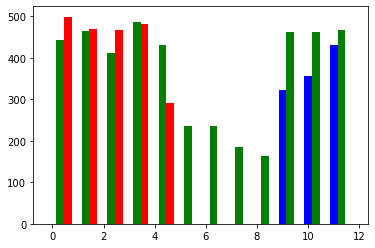

In [23]:
# # The final processing I want to do is to try using dictVectorization on the description and try 
# # TF_IDF score as well. Before splitting into 2 datasets (vectorizatoin vs TF_IDF) I want to split train and validation sets.
# # Because this is with time data I want the train and validation set to have an equal mix from each season.

data_2017_monthly = []
data_2018_monthly = []
data_2019_monthly = []

for year in [2017, 2018, 2019]:
    data_year = processed_data_vect[processed_data_vect['Year'] == year] 
    for i in range(1, 13):
        if year == 2017:
            data_2017_monthly.append(len(data_year[data_year['Month'] == i]))
        elif year == 2018:
            data_2018_monthly.append(len(data_year[data_year['Month'] == i]))
        else:
            data_2019_monthly.append(len(data_year[data_year['Month'] == i]))

width = 0.3
plt.bar(np.arange(len(data_2017_monthly)), data_2017_monthly, width=width, color='b')
plt.bar(np.arange(len(data_2018_monthly)) + width, data_2018_monthly, width=width, color='g')
plt.bar(np.arange(len(data_2019_monthly)) + 2 * width, data_2019_monthly, width=width, color='r')

plt.show()

We can see we have a lot of posts from different times. Let's think about why this is important.

Instagram pages tend to grow over time, so if we train only on 2017 data, we will be inaccurate in 2019 because of organic growth.

We can see from the bar chart there are signifigantly less posts from 06 - 09. This is because this is the NBA off season.

I won't plot it but it would be fair to assume engagements are also low beacause there is very little content to post.

If we fail to train on those summer months or only train on those summer months we will miss that relationship.

I wanted my training set to be 75% of the data and my validation to be 30%. 

In order to capture the relationships outlined above I took the 75-25 ratio for each month of data.

In [24]:
# The training set will be 75% of the data
# 75% of posts for each month will go to training to get 75-25 ratio
train_data_processed = pd.DataFrame(columns=list(processed_data_vect.columns))
validation_data_processed = pd.DataFrame(columns=list(processed_data_vect.columns))

years = [2017, 2018, 2019]

for year in years:
    data_year = processed_data_vect[processed_data_vect['Year'] == year]
    for month in range(1, 13):
        data_month = data_year[data_year['Month'] == month]
        if len(data_month) > 0:
            train, validation = train_test_split(data_month, test_size=0.25)
            train_data_processed = train_data_processed.append(train, ignore_index=True)
            validation_data_processed = validation_data_processed.append(validation, ignore_index=True)
            
print(train_data_processed.shape)
validation_data_processed.shape

(5819, 7298)


(1947, 7298)

In [49]:
# The training set will be 70% of the data
# 70% of posts for each month will go to training to get 70-30 ratio
train_data_dummy = pd.DataFrame(columns=list(dummy_data_vect.columns))
validation_data_dummy = pd.DataFrame(columns=list(dummy_data_vect.columns))

years = [2017, 2018, 2019]

for year in years:
    data_year = dummy_data_vect[dummy_data_vect['Year_' + str(year)] == 1]
    for month in range(1, 13):
        if month < 10:
            month = '0' + str(month)
        data_month = data_year[data_year['Month_' + str(month)] == 1]
        if len(data_month) > 0:
            train, validation = train_test_split(data_month, test_size=0.25)
            train_data_dummy = train_data_dummy.append(train, ignore_index=True)
            validation_data_dummy = validation_data_dummy.append(validation, ignore_index=True)
            
print(train_data_dummy.shape)
validation_data_dummy.shape

(5819, 7482)


(1947, 7482)

We now have 5819 posts for training and 1947 posts for validating for each set.

We can also be fairly certain our training and validation sets are balanced to account for differences in time!

## Using the Models

Lets get the names of all the features we need.

In [50]:
features_processed = list(train_data_processed.columns)
features_processed.remove('Engagements')
features_processed.remove('word_count')

features_dummy = list(train_data_dummy.columns)
features_dummy.remove('Engagements')
features_dummy.remove('word_count')

target = ['Engagements']

Taking a guess I would expect Random Forest and Adaboost to perform the best since I am almost certain the relationship is nonlinear.

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf = RandomForestRegressor()
rf.fit(train_data_processed[features_processed], train_data_processed[target])

predictions = rf.predict(validation_data_processed[features_processed])
mean_squared_error(validation_data_processed[target], predictions)

0.09272168500360255

In [51]:
rf.fit(train_data_dummy[features_dummy], train_data_dummy[target])

predictions = rf.predict(validation_data_dummy[features_dummy])
mean_squared_error(validation_data_dummy[target], predictions)

0.08632575849256786

In [57]:
from sklearn.ensemble import AdaBoostRegressor

ada = AdaBoostRegressor()
ada.fit(train_data_processed[features_processed], train_data_processed[target])

predictions = ada.predict(validation_data_processed[features_processed])
mean_squared_error(validation_data_processed[target], predictions)

0.19383062604052792

In [58]:
ada.fit(train_data_dummy[features_dummy], train_data_dummy[target])

predictions = ada.predict(validation_data_dummy[features_dummy])
mean_squared_error(validation_data_dummy[target], predictions)

0.19174296443025207

We can see that RandomForest outperformed Adaboost and the **dummy_data** dataset worked better than the **processed_data** dataset.

Now we can test out Linear models.

In [55]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(train_data_processed[features_processed], train_data_processed[target])

predictions = reg.predict(validation_data_processed[features_processed])
mean_squared_error(validation_data_processed[target], predictions)

1.1330911452542401e+18

In [56]:
reg.fit(train_data_dummy[features_dummy], train_data_dummy[target])

predictions = reg.predict(validation_data_dummy[features_dummy])
mean_squared_error(validation_data_dummy[target], predictions)

7.941957627852141e+19

In [59]:
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge.fit(train_data_processed[features_processed], train_data_processed[target])

predictions = ridge.predict(validation_data_processed[features_processed])
mean_squared_error(validation_data_processed[target], predictions)

0.16821450341994884

In [60]:
ridge.fit(train_data_dummy[features_dummy], train_data_dummy[target])

predictions = ridge.predict(validation_data_dummy[features_dummy])
mean_squared_error(validation_data_dummy[target], predictions)

0.15357345562447816

In [61]:
from sklearn.linear_model import Lasso

lasso = Lasso()
lasso.fit(train_data_processed[features_processed], train_data_processed[target])

predictions = lasso.predict(validation_data_processed[features_processed])
mean_squared_error(validation_data_processed[target], predictions)

0.9955155348348725

In [62]:
lasso.fit(train_data_dummy[features_dummy], train_data_dummy[target])

predictions = lasso.predict(validation_data_dummy[features_dummy])
mean_squared_error(validation_data_dummy[target], predictions)

0.9852190755641356

In [63]:
from sklearn.linear_model import ElasticNet

en = ElasticNet()
en.fit(train_data_processed[features_processed], train_data_processed[target])

predictions = en.predict(validation_data_processed[features_processed])
mean_squared_error(validation_data_processed[target], predictions)

0.9761124927174879

In [65]:
en.fit(train_data_dummy[features_dummy], train_data_dummy[target])

predictions = en.predict(validation_data_dummy[features_dummy])
mean_squared_error(validation_data_dummy[target], predictions)

0.9604046437342361

None of them performed particularly well. Having a MSE of around 1 means on average it is about a full standard deviation off... not too good.